In [1]:
import pandas as pd
import numpy as np
import ast
import os

# 多步法按batch合并数据

In [2]:
model_list = ['vit_b_16', 'resnet50', 'vgg16']
# model_list = ['vgg16']

data_root = './data_stage3/multi_step_total100_fixed_1122'
save_result_file = 'result_multi_step_total100_fixed_1122.xlsx'

In [3]:
data1 = pd.read_excel(os.path.join(data_root, f'{model_list[0]}', f'{model_list[0]}_{save_result_file}'))
data2 = pd.read_excel(os.path.join(data_root, f'{model_list[1]}', f'{model_list[1]}_{save_result_file}'))
data3 = pd.read_excel(os.path.join(data_root, f'{model_list[2]}', f'{model_list[2]}_{save_result_file}'))
print(data1.shape)
print(data2.shape)
print(data3.shape)

(104400, 15)
(104400, 15)
(127200, 15)


In [4]:
def l1_norm(series):
    return series.abs().sum()

def l2_norm(series):
    return np.sqrt((series ** 2).sum())

def calculate_eta_reverse(row):
    if row['mask_mode'] in ('cam_lowr', 'lowr', 'seed_randomr_lowr', 'channel_lowr'):
        return 1 - row['parameter']
    else:
        return row['parameter']

def merge_batch_onestep(data): 
    '''将多个batch的数据合并''' 
    data['parameter'] = data['parameter'].fillna(-1)
    li = ['model', 'algo', 'alpha', 'mask_mode', 'step', 'parameter', 'eta']
    data_grouped = data.groupby(li).agg({
        'l1_norm': l1_norm,
        'l2_norm': l2_norm,
        'loss': 'mean',
        'pred_loss': 'mean',
        'success_rate': lambda x: round(x.mean(), 4),
        'run_time': 'sum',
        'batch_pictures': 'sum'
    }).reset_index()
    data_grouped['parameter0'] = data_grouped.apply(calculate_eta_reverse, axis=1)
    # 将'loss'列命名为'attack_loss'
    data_grouped = data_grouped.rename(columns={'loss': 'attack_loss'})
    return data_grouped

In [5]:
data1_grouped = merge_batch_onestep(data1)
data2_grouped = merge_batch_onestep(data2)
data3_grouped = merge_batch_onestep(data3)

In [6]:
data_grouped = pd.concat([data1_grouped, data2_grouped, data3_grouped], axis=0)
print(data_grouped.shape)
data_grouped.head()

(168000, 15)


,model,algo,alpha,mask_mode,step,parameter,eta,l1_norm,l2_norm,attack_loss,pred_loss,success_rate,run_time,batch_pictures,parameter0
0,vit_b_16,i_fgsm,0.0001,all,0,-1.0,0.01,322.2228,0.218148,0.129736,0.129736,0.0,209.78,100,-1.0
1,vit_b_16,i_fgsm,0.0001,all,1,-1.0,0.01,168.1469,0.045632,0.137750,0.137985,0.0,209.78,100,-1.0
2,vit_b_16,i_fgsm,0.0001,all,2,-1.0,0.01,182.6081,0.078490,0.146638,0.146942,0.0,209.78,100,-1.0
3,vit_b_16,i_fgsm,0.0001,all,3,-1.0,0.01,187.4057,0.049670,0.155498,0.157145,0.0,209.78,100,-1.0
4,vit_b_16,i_fgsm,0.0001,all,4,-1.0,0.01,197.0542,0.054358,0.164776,0.168450,0.0,209.78,100,-1.0


In [7]:
data_grouped.to_excel(os.path.join(data_root, save_result_file), index=False)

In [20]:
# 按 li 列进行分组，并只保留 step 为 0 和 step 最大的数据
li = ['model', 'algo', 'alpha', 'mask_mode', 'parameter', 'eta']
def filter_steps(group):
    return group[(group['step'] == 0) | (group['step'] == group['step'].max())]

df_filtered = data_grouped.groupby(li).apply(filter_steps).reset_index(drop=True)
print(df_filtered.shape)
df_filtered.head()

(1120, 15)


/tmp/ipykernel_2247739/2499813439.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = data_grouped.groupby(li).apply(filter_steps).reset_index(drop=True)


,model,algo,alpha,mask_mode,step,parameter,eta,l1_norm,l2_norm,attack_loss,pred_loss,success_rate,run_time,batch_pictures,parameter0
0,resnet50,i_fgsm,0.0001,all,0,-1.00,0.01,472.5571,0.151563,0.120220,0.120220,0.0000,36.032,100,-1.00
1,resnet50,i_fgsm,0.0001,all,299,-1.00,0.01,3604.5719,2.778723,14.693677,14.880566,0.9922,36.032,100,-1.00
2,resnet50,i_fgsm,0.0001,cam_lowr,0,0.05,0.01,13.1443,0.001470,0.120220,0.120220,0.0000,37.014,100,0.95
3,resnet50,i_fgsm,0.0001,cam_lowr,299,0.05,0.01,7.8231,0.000709,0.155525,0.153339,0.0234,37.014,100,0.95
4,resnet50,i_fgsm,0.0001,cam_lowr,0,0.10,0.01,26.4838,0.003010,0.120220,0.120220,0.0000,36.830,100,0.90


In [21]:
df_filtered.to_excel(os.path.join(data_root, f'filtered_{save_result_file}'), index=False)

# 结果分析

In [ ]:
data_grouped = pd.read_excel('./data_stage3/multi_step_total100_fixed_1122/result_multi_step_total100_fixed_1122.xlsx')
data_grouped.head()

In [ ]:
df_filtered = pd.read_excel('./data_stage3/multi_step_total100_fixed_1122/filtered_result_multi_step_total100_fixed_1122.xlsx')

In [9]:
for column in df_filtered.columns:
    if column not in ('l1_norm', 'l2_norm', 'success_rate', 'run_time', 'step', 'pred_loss', 'attack_loss'):
        unique_values = df_filtered[column].unique()
        print(f"字段 '{column}' 的唯一值: {unique_values}")
print(df_filtered.columns)

字段 'model' 的唯一值: ['vgg16']
字段 'algo' 的唯一值: ['i_fgsm']
字段 'alpha' 的唯一值: [0.0001]
字段 'mask_mode' 的唯一值: ['all' 'cam_lowr' 'cam_topr' 'channel_lowr' 'channel_topr' 'lowr'
 'lrp_lowr' 'lrp_topr' 'negative' 'positive' 'randomr' 'seed_randomr'
 'seed_randomr_lowr' 'topr']
字段 'parameter' 的唯一值: [-1.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95]
字段 'eta' 的唯一值: [0.01]
字段 'batch_pictures' 的唯一值: [100]
字段 'parameter0' 的唯一值: [-1.    0.95  0.9   0.85  0.8   0.75  0.7   0.65  0.6   0.55  0.5   0.45
  0.4   0.35  0.3   0.25  0.2   0.15  0.1   0.05  0.05  0.1   0.15  0.2
  0.25  0.3   0.35  0.4   0.45  0.6   0.65  0.7   0.75  0.85  0.9   0.95]
Index(['model', 'algo', 'alpha', 'mask_mode', 'step', 'parameter', 'eta',
       'l1_norm', 'l2_norm', 'attack_loss', 'pred_loss', 'success_rate',
       'run_time', 'batch_pictures', 'parameter0'],
      dtype='object')


# 画图分析

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import os

font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'  # 显示中文字体

if not os.path.exists(font_path):
    print(f"字体文件 {font_path} 未找到。请确保字体文件存在于工作目录中。")
else:
    # 创建FontProperties对象
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = font_prop.get_name()

In [11]:
from tools.show_result_multi_step import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 先只看结果（只关注step0和最后一步攻击的结果）

In [12]:
data_root = './data_stage3/multi_step_total100_fixed_1122'

In [22]:
data_result = pd.read_excel('./data_stage3/multi_step_total100_fixed_1122/filtered_result_multi_step_total100_fixed_1122.xlsx')
data_result.head()

,model,algo,alpha,mask_mode,step,parameter,eta,l1_norm,l2_norm,attack_loss,pred_loss,success_rate,run_time,batch_pictures,parameter0
0,resnet50,i_fgsm,0.0001,all,0,-1.00,0.01,472.5571,0.151563,0.120220,0.120220,0.0000,36.032,100,-1.00
1,resnet50,i_fgsm,0.0001,all,299,-1.00,0.01,3604.5719,2.778723,14.693677,14.880566,0.9922,36.032,100,-1.00
2,resnet50,i_fgsm,0.0001,cam_lowr,0,0.05,0.01,13.1443,0.001470,0.120220,0.120220,0.0000,37.014,100,0.95
3,resnet50,i_fgsm,0.0001,cam_lowr,299,0.05,0.01,7.8231,0.000709,0.155525,0.153339,0.0234,37.014,100,0.95
4,resnet50,i_fgsm,0.0001,cam_lowr,0,0.10,0.01,26.4838,0.003010,0.120220,0.120220,0.0000,36.830,100,0.90


In [23]:
# 新增列end，如果step = 0，end = 0；否则end = 1
data_result['end'] = data_result['step'].apply(lambda x: 0 if x == 0 else 1)
data_result.head()

,model,algo,alpha,mask_mode,step,parameter,eta,l1_norm,l2_norm,attack_loss,pred_loss,success_rate,run_time,batch_pictures,parameter0,end
0,resnet50,i_fgsm,0.0001,all,0,-1.00,0.01,472.5571,0.151563,0.120220,0.120220,0.0000,36.032,100,-1.00,0
1,resnet50,i_fgsm,0.0001,all,299,-1.00,0.01,3604.5719,2.778723,14.693677,14.880566,0.9922,36.032,100,-1.00,1
2,resnet50,i_fgsm,0.0001,cam_lowr,0,0.05,0.01,13.1443,0.001470,0.120220,0.120220,0.0000,37.014,100,0.95,0
3,resnet50,i_fgsm,0.0001,cam_lowr,299,0.05,0.01,7.8231,0.000709,0.155525,0.153339,0.0234,37.014,100,0.95,1
4,resnet50,i_fgsm,0.0001,cam_lowr,0,0.10,0.01,26.4838,0.003010,0.120220,0.120220,0.0000,36.830,100,0.90,0


findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not 

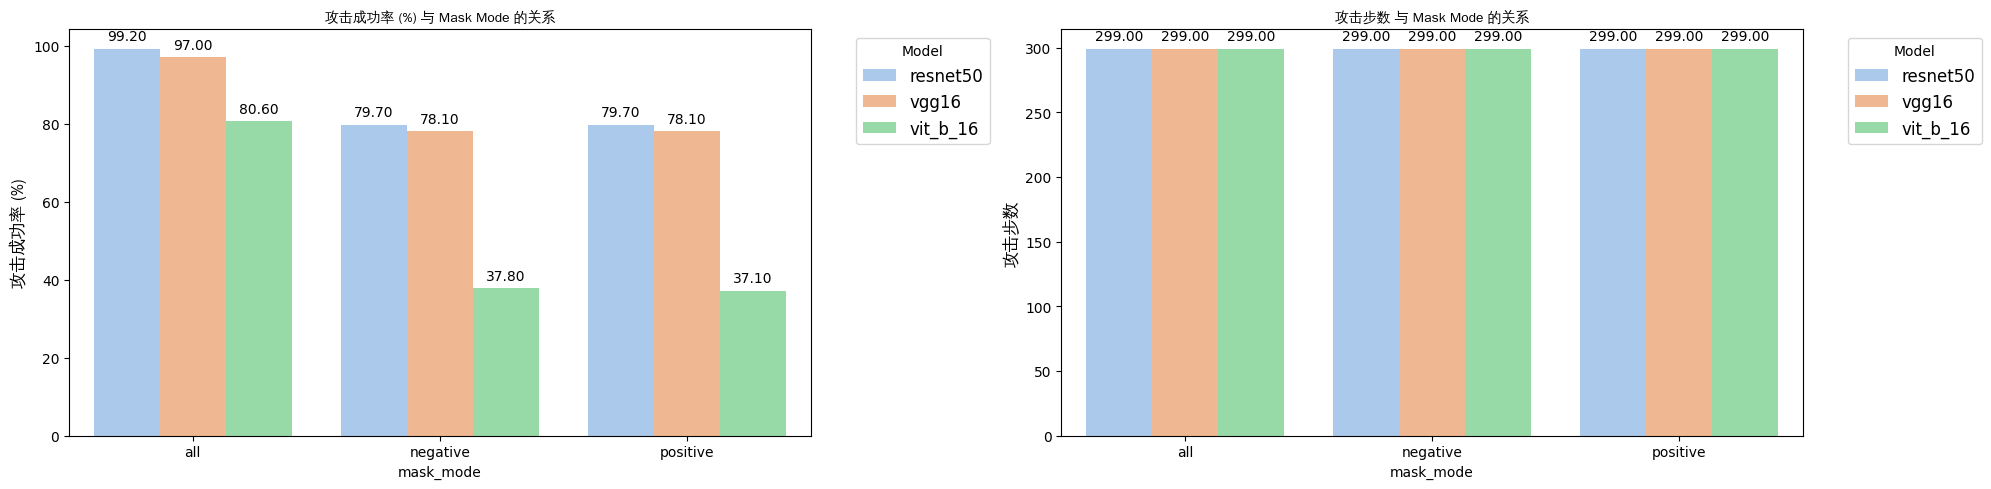

In [25]:
plot_success_rate_vs_mask_mode(data_result, output_path=data_root, save_name='success_rate_vs_mask_mode')

In [50]:
def plot_success_rate_vs_r0(data, var, label_list, **kwargs):
    '''
    绘制不同模型下，各个标签（label）与参数（parameter）的关系图。
    每个子图表示一个模型和一个标签的关系，图例表示不同的 mask_mode。

    Args:
        data (pd.DataFrame): 数据集
        var: x轴参数
        label_list (list): 需要绘制的标签列表，例如 ['success_rate', 'l1_norm', 'l2_norm', 'loss', 'step']
    '''
    output_path = kwargs.get('output_path', None)
    save_name = kwargs.get('save_name', None)
    
    # 获取唯一的模型和mask_mode
    model_list = ['vit_b_16', 'resnet50', 'vgg16']
    mask_mode_list = kwargs.get('mask_mode_list', data['mask_mode'].unique())
    
    df_filtered = data[(data['end'] == 1) & (data['mask_mode'].isin(mask_mode_list))].copy()
    df_filtered = df_filtered.reset_index(drop=True)
    
    ncols = kwargs.get('ncols', len(label_list))
    nrows = kwargs.get('nrows', len(model_list))

    sns.set(style="whitegrid", rc={"grid.linestyle": "--", "grid.color": "0.8"})

    palette = sns.color_palette("tab10", n_colors=len(mask_mode_list))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4), squeeze=False)
    axes = axes.flatten()

    for i, model in enumerate(model_list):
        df_model = df_filtered[df_filtered['model'] == model]
        for j, label in enumerate(label_list):
            ax = axes[i * len(label_list) + j]
            
            # 筛选需要绘制的数据
            df_plot = df_model[[var, 'mask_mode', label]].dropna()
            sns.lineplot(
                data=df_plot, 
                x=var, 
                y=label, 
                hue='mask_mode', 
                hue_order=mask_mode_list,
                ax=ax, 
                # marker='o', 
                palette=palette
            )
            
            # 设置子图标题和轴标签
            ax.set_title(f"Model: {model} | {label}", fontsize=12)
            ax.set_xlabel(f'{var}', fontsize=10)
            ax.set_ylabel(label, fontsize=10)
            ax.tick_params(axis='x')
            
            # 移除子图中的图例
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()
            
    # 隐藏多余的子图
    total_subplots = nrows * ncols
    used_subplots = len(model_list) * len(label_list)
    for idx in range(used_subplots, total_subplots):
        axes[idx].axis('off')
    
    # 调整子图布局
    plt.tight_layout()
    
    # 添加图例到整个图像的最下面
    if_legend = kwargs.get('if_legend', True)
    if if_legend:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, title='Mask Mode', loc='lower center', bbox_to_anchor=(0.5, -0.06), ncol=len(mask_mode_list), fontsize=9)
    
    # 增加底部边距以避免图例挡住子图的坐标轴下方的文字
    plt.subplots_adjust(bottom=0.2)
    
    if output_path and save_name:
        plt.savefig(f'{output_path}/{save_name}.png', dpi=300, bbox_inches='tight')
    else:
        plt.show()

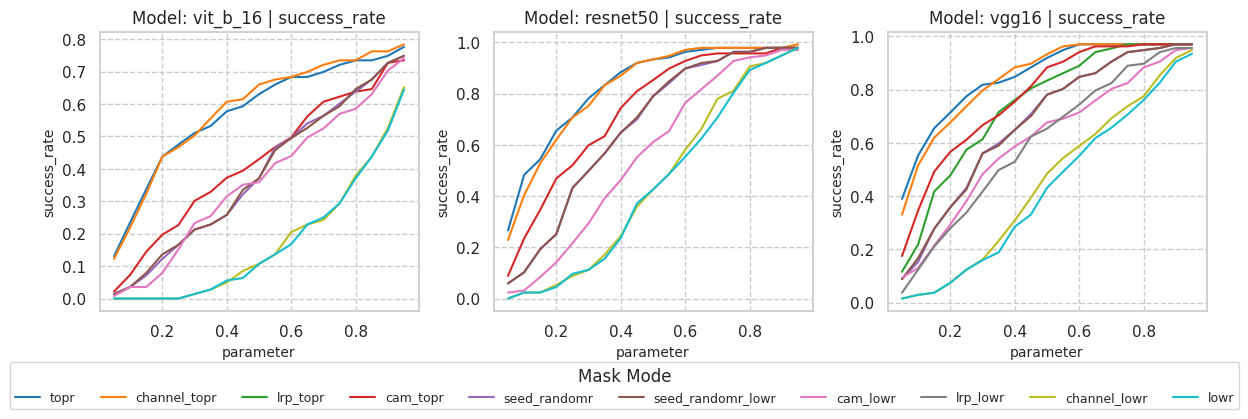

In [51]:
# label_list = ['success_rate', 'attack_loss']
label_list = ['success_rate']
model_list = ['vit_b_16', 'resnet50', 'vgg16']
mask_mode_list = ['topr', 'channel_topr', 'lrp_topr', 'cam_topr', 'seed_randomr', 'seed_randomr_lowr', 'cam_lowr', 'lrp_lowr','channel_lowr', 'lowr']

# mask_mode_list = ['topr', 'channel_topr', 'cam_topr', 'seed_randomr', 'seed_randomr_lowr', 'cam_lowr', 'channel_lowr', 'lowr']

plot_success_rate_vs_r0(data_result, var = 'parameter', label_list = label_list, output_path=data_root, save_name='multi_only_success_rate_vs_parameter', ncols=3, nrows=1, mask_mode_list=mask_mode_list, model_list=model_list)

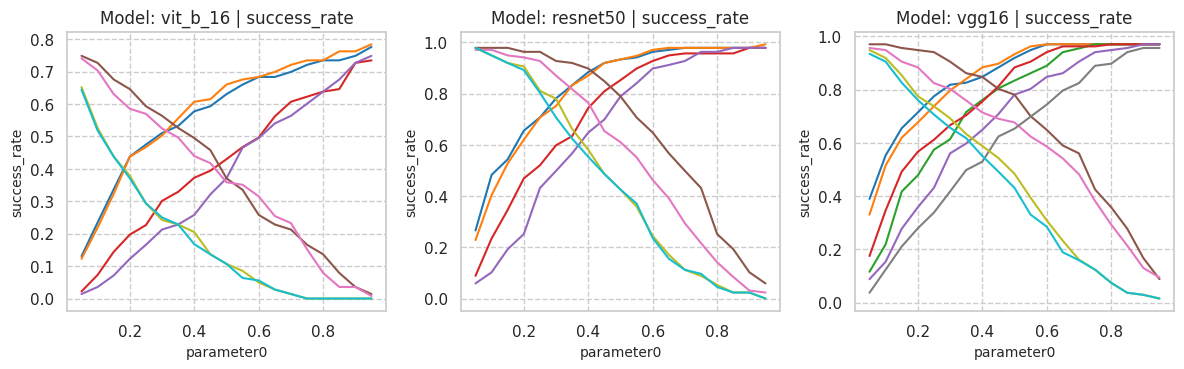

In [52]:
label_list = ['success_rate']
plot_success_rate_vs_r(data_result, var = 'parameter0', label_list = label_list, output_path=data_root, save_name='success_rate_vs_parameter0', ncols=3, nrows=1, mask_mode_list=mask_mode_list, if_legend=False)    

## 完整数据，查看攻击每一步的过程中指标的变化

In [40]:
data_all = pd.read_excel('./data_stage3/multi_step_total100_fixed_1122/result_multi_step_total100_fixed_1122.xlsx')
data_all.head()

,model,algo,alpha,mask_mode,step,parameter,eta,l1_norm,l2_norm,attack_loss,pred_loss,success_rate,run_time,batch_pictures,parameter0
0,vit_b_16,i_fgsm,0.0001,all,0,-1.0,0.01,322.2228,0.218148,0.129736,0.129736,0.0,209.78,100,-1.0
1,vit_b_16,i_fgsm,0.0001,all,1,-1.0,0.01,168.1469,0.045632,0.137750,0.137985,0.0,209.78,100,-1.0
2,vit_b_16,i_fgsm,0.0001,all,2,-1.0,0.01,182.6081,0.078490,0.146638,0.146942,0.0,209.78,100,-1.0
3,vit_b_16,i_fgsm,0.0001,all,3,-1.0,0.01,187.4057,0.049670,0.155498,0.157145,0.0,209.78,100,-1.0
4,vit_b_16,i_fgsm,0.0001,all,4,-1.0,0.01,197.0542,0.054358,0.164775,0.168450,0.0,209.78,100,-1.0


In [54]:
def plot_success_rate_vs_step1(data, parameter, var, label_list, **kwargs):
    '''
    绘制不同模型下，各个标签（label）与参数（parameter）的关系图。
    每个子图表示一个模型和一个标签的关系，图例表示不同的 mask_mode。

    Args:
        data (pd.DataFrame): 数据集
        parameter (str): 攻击比例
        var: x轴参数, 例如 'step'
        label_list (list): 需要绘制的标签列表，例如 ['success_rate', 'l1_norm', 'l2_norm', 'loss', 'step']
    '''
    output_path = kwargs.get('output_path', None)
    save_name = kwargs.get('save_name', None)
    model_list = kwargs.get('model_list', ['vit_b_16', 'resnet50', 'vgg16'])

    mask_mode_list = kwargs.get('mask_mode_list', data['mask_mode'].unique())
    
    
    df_filtered = data[(data['mask_mode'].isin(mask_mode_list)) & (data['parameter'] == parameter)]
    df_filtered = df_filtered.reset_index(drop=True)
    
    ncols = kwargs.get('ncols', len(label_list))
    nrows = kwargs.get('nrows', len(model_list))

    sns.set(style="whitegrid")
    palette = sns.color_palette("tab10", n_colors=len(mask_mode_list))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4), squeeze=False)
    axes = axes.flatten()

    for i, model in enumerate(model_list):
        df_model = df_filtered[df_filtered['model'] == model]
        for j, label in enumerate(label_list):
            ax = axes[i * len(label_list) + j]
            
            # 筛选需要绘制的数据
            df_plot = df_model[[var, 'mask_mode', label]].dropna()
            sns.lineplot(
                data=df_plot, 
                x=var, 
                y=label, 
                hue='mask_mode', 
                hue_order=mask_mode_list, 
                ax=ax, 
                # marker='o', 
                palette=palette
            )
            
            # 设置子图标题和轴标签
            ax.set_title(f"Model: {model} | {label}", fontsize=12)
            ax.set_xlabel(f'{var}', fontsize=10)
            ax.set_ylabel(label, fontsize=10)
            ax.tick_params(axis='x')
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()
            
    # 隐藏多余的子图
    total_subplots = nrows * ncols
    used_subplots = len(model_list) * len(label_list)
    for idx in range(used_subplots, total_subplots):
        axes[idx].axis('off')
    
    # 调整子图布局
    plt.tight_layout()

    if_legend = kwargs.get('if_legend', True)
    if if_legend:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, title='Mask Mode', loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(mask_mode_list), fontsize=9)

    plt.subplots_adjust(bottom=0.25)
    
    if output_path and save_name:
        plt.savefig(f'{output_path}/{save_name}.png', dpi=300)
    else:
        plt.show()


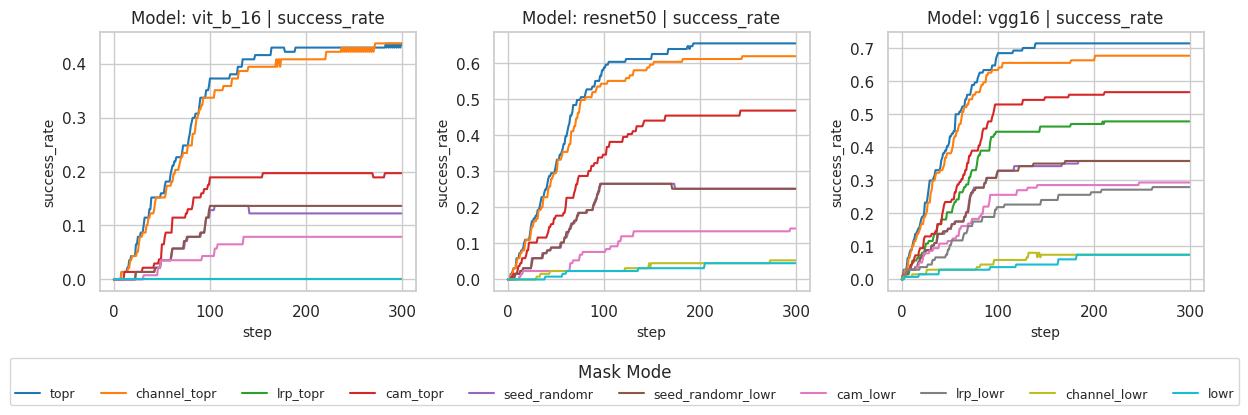

In [55]:
label_list = ['success_rate']
r = 0.2
# mask_mode_list = ['topr', 'channel_topr',  'cam_topr', 'seed_randomr', 'seed_randomr_lowr', 'cam_lowr', 'channel_lowr', 'lowr']
mask_mode_list = ['topr', 'channel_topr', 'lrp_topr', 'cam_topr', 'seed_randomr', 'seed_randomr_lowr', 'cam_lowr', 'lrp_lowr','channel_lowr', 'lowr']
plot_success_rate_vs_step1(data_all, r, 'step', label_list, output_path=data_root, save_name=f'r={r}_success_rate_vs_step', ncols=3, nrows=1, suptitle=f'r = {r}: Success Rate vs. Step', mask_mode_list=mask_mode_list)

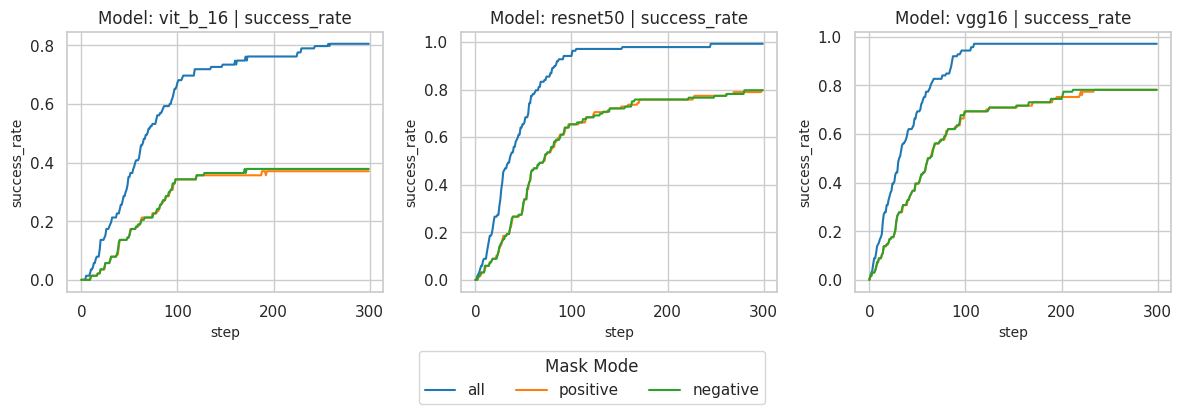

In [48]:
label_list = ['success_rate']
r = -1
mask_mode_list = ['all', 'positive', 'negative']
plot_success_rate_vs_step(data_all, r, 'step', label_list, output_path=data_root, save_name=f'r={r}_success_rate_vs_step', ncols=3, nrows=1, suptitle=f'r = {r}: Success Rate vs. Step', mask_mode_list=mask_mode_list)

# 画出pred_loss和attack_loss的散点图

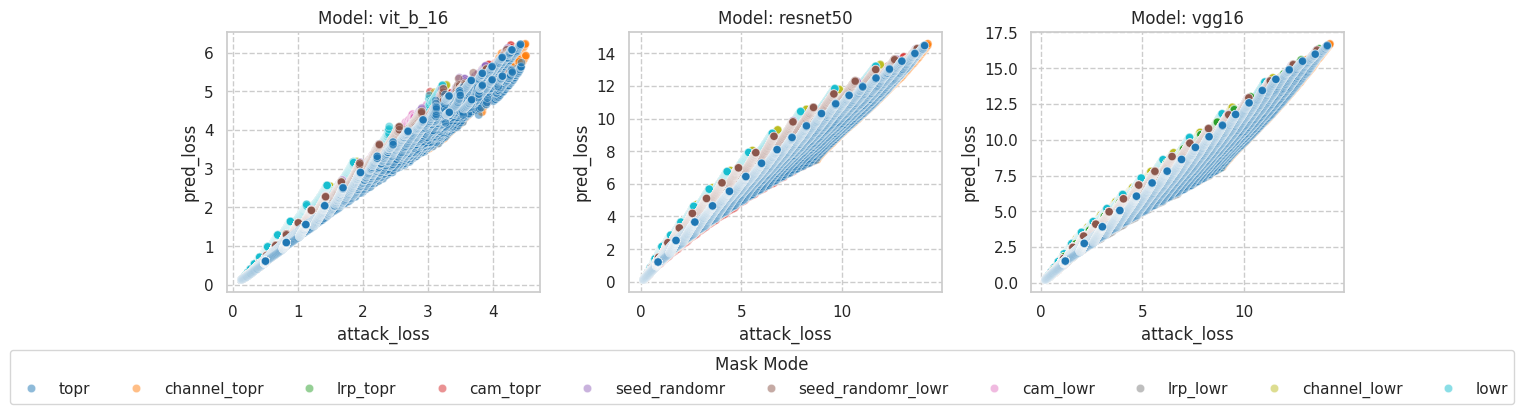

In [43]:
mask_mode_list = ['topr', 'channel_topr', 'lrp_topr', 'cam_topr', 'seed_randomr', 'seed_randomr_lowr', 'cam_lowr', 'lrp_lowr','channel_lowr', 'lowr']
plot_loss_vs_pred_loss(data_all, output_path=data_root, save_name='loss_vs_pred_loss',mask_mode_list = mask_mode_list)

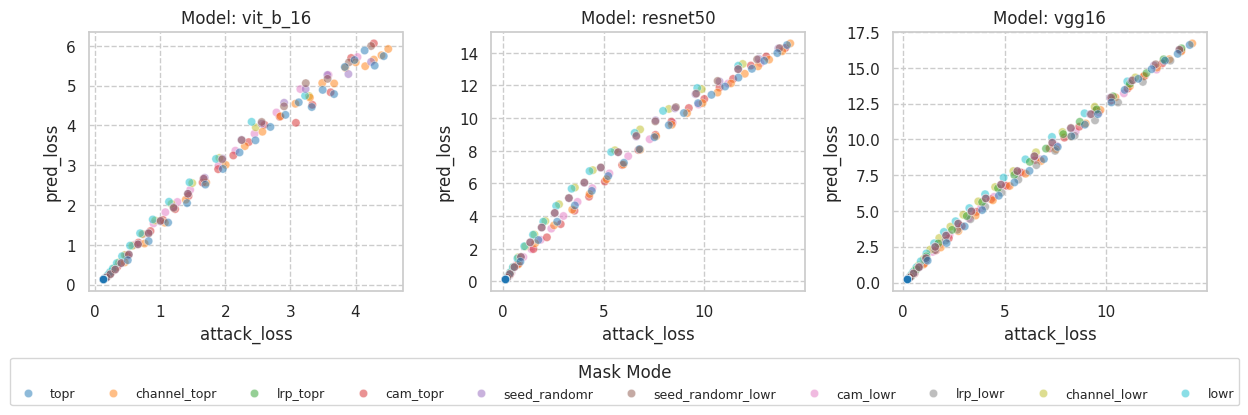

In [ ]:
plot_loss_vs_pred_loss(data_result, output_path=data_root, save_name='filtered_loss_vs_pred_loss', mask_mode_list = mask_mode_list)